In [2]:
import numpy as np
import libpysal as ps 
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
# from viz_gwr import shift_colormap, truncate_colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
# from svcviz.viz_gwr import viz_gwr, viz_gw, compare_conf, compare_two_surf
# import ipywidgets as widgets
from IPython.display import display
import geopandas as gpd
import pandas as pdz
import libpysal as ps 
from mgwr.gwr import GWR
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, HTML
import geopandas as gpd
import pandas as pd
import libpysal as ps 
from mgwr.gwr import GWR
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


### Load in your data and preprocess it

In [3]:
df = pd.read_csv("countypres_2000-2020.csv")
df2 = pd.read_csv("voting_2020.csv")[["county_id","pct_black", "total_pop", 
                                                "pct_hisp", "median_income",
                                               "pct_65_over", "pct_age_18_29", 
                                                "pct_fb", "sex_ratio", "ln_pop_den",
                                               "pct_bach", "pct_uninsured", "median_income"]]

dfgp  = pd.read_csv("ggp-us-dfii.csv").drop('delete', axis=1)

df3 = dfgp[['id', 'se0', 'b0', 'Intercept','sepct_black',
       'bpct_black', 'sepct_hisp', 'bpct_hisp', 'sepct_65_over', 'bpct_65_over', 'sepct_age_18_29',
       'bpct_age_18_29', 'sepct_fb', 'bpct_fb', 'sepct_uninsured',
       'bpct_uninsured', 'sepct_bach', 'bpct_bach', 'seln_pop_den',
       'bln_pop_den']]

In [4]:
df = df[(df.year==2020) & (df.party=='DEMOCRAT') & (df.state!='DISTRICT OF COLUMBIA')] 

In [5]:
df = df[["state", "county_name", "county_fips","party", "totalvotes", "mode"]]

In [6]:
# df3.head(2)

In [7]:
newdf = df.merge(df2, left_on='county_fips', right_on='county_id', how='right')

In [8]:
newdf = newdf[(newdf['mode']=='TOTAL') | (newdf['mode']=='ELECTION DAY')]

In [9]:
counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)

empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty].copy()

counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')

In [10]:
data = counties_non_empty.merge(newdf, left_on='id', right_on='county_fips')

In [11]:
data = data[data.state!='HAWAII']

In [12]:
data.set_crs(epsg=4269, allow_override=True, inplace=True)
data = data.to_crs(epsg=4269)

In [13]:
data['geometry'] = data.buffer(0)
# gpd.GeoSeries(data.unary_union.boundary).plot(figsize=(18,12))
# plt.show()


In [14]:
# data.boundary.plot(figsize=(18,12));

In [15]:
g_y = data['totalvotes'].values.reshape((-1,1))
g_X = data[[
    'pct_black','pct_hisp','pct_65_over','pct_age_18_29',
            'pct_fb', 'pct_uninsured', 'pct_bach', 'ln_pop_den'
            ]].values

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

u = data["lon"]
v = data["lat"]

g_coords = list(zip(u,v))

In [16]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()
print('Bandwidth is:', gwr_bw)
print('=======================')
print('Resid SS is:', gwr_results.resid_ss)
print('=======================')
print('ENP is:', gwr_results.ENP)
print('=======================')
print('AICc is:', gwr_results.aicc)

# gwr_results.summary()

Bandwidth is: 143.0
Resid SS is: 904.7533722425308
ENP is: 451.3961065192949
AICc is: 6058.043970785431


In [17]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3134
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1987.377
Log-likelihood:                                                   -3733.194
AIC:                                                               7484.387
AICc:                                                              7486.458
BIC:                                                             -23169.077
R2:                                                                   0.366
Adj. R2:                                                              0.364

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search()
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

In [18]:
# mgwr = MGWR(g_coords, g_y, g_X, selector, constant=True)

In [19]:
# gwr_results.critical_tval()

In [23]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3134
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1987.377
Log-likelihood:                                                   -3733.194
AIC:                                                               7484.387
AICc:                                                              7486.458
BIC:                                                             -23169.077
R2:                                                                   0.366
Adj. R2:                                                              0.364

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

<br />

# Demo

### Utility 1 

- This Utillity of the "svc-viz" tool takes as input a GWR model object and generates coefficient surfaces incorporating the visualization best practices discussed in the paper to ensure reproducible research

- By default the tool visualizes all the coefficients. The User then only needs to specify which coefficient surfaces they want to visualize by passing them as argument and they could turn the t-values on/off (by default the tvalues are at 0.05 significance level but could be adjusted)

- A pretty cool thing is it could also be used for other svc models that are not GWR

- Below is an example code with a gwr model object

In [18]:
## imports
from viz_gwr import viz_gwr
from viz_gwr import viz_gwstat
from viz_gwr import compare_conf


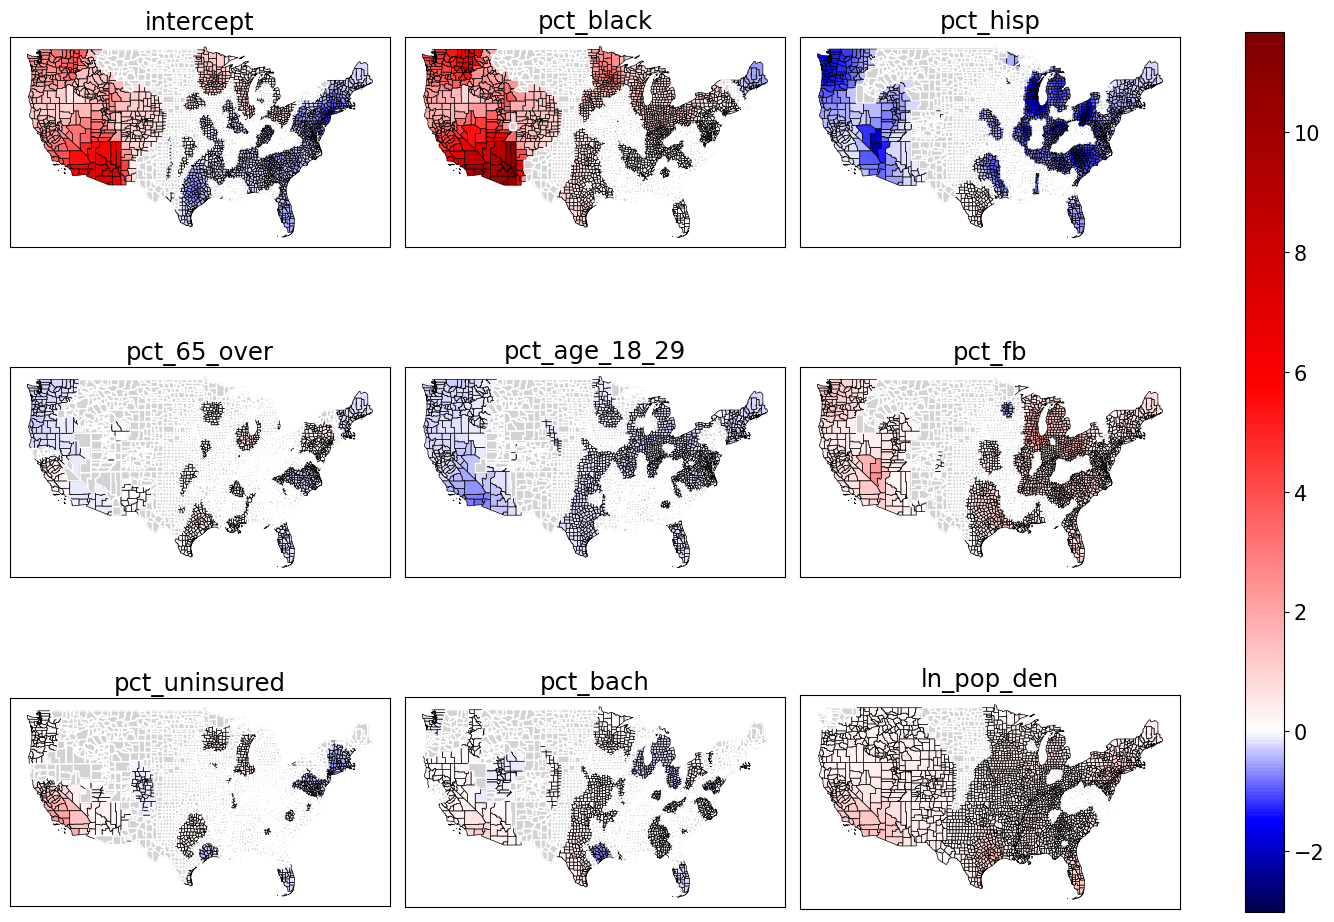

In [19]:
col_names = ['pct_black', 'pct_hisp', 'pct_65_over', 'pct_age_18_29', 'pct_fb', 
    'pct_uninsured', 'pct_bach', 'ln_pop_den']

viz_gwr(
        col_names, 
        data['geometry'], 
        gwr_results, 
        use_tvalues=True, 
        alpha=0.5,   
#         coef_surfaces=['intercept']
)

#### User specifies what surfaces they want to visualize, following best practices we recommend in the paper

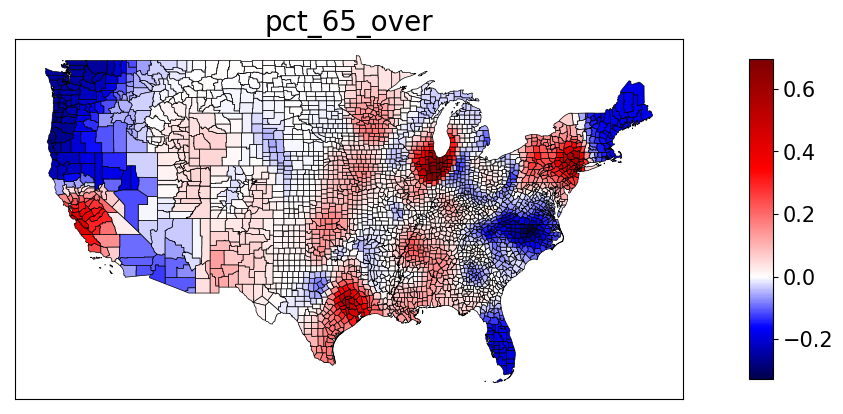

In [22]:
viz_gwr(
        col_names, 
        data['geometry'], 
        gwr_results, 
        use_tvalues=False, 
        alpha=0.5, 
        coef_surfaces=['pct_65_over']
)

- In addition to the Utility 1 for GWR models, the tool also has the functionality for creating a 3-panel visualization which is essential a multiview visualization that displays different yet relating information about a single variable, including bandwidth and its confidence intervals, a carterpillar plot visualizing the confidence intervals, and finally the coefficient surface.

- It takes as input the bandwidth object and the gwr result objects. 

<br/>

<br/>

## Utility 2


- The svc-viz is not only restricted to GWR models but can also be extended to any other svc model or geographically weighted statistic. 

- It takes in as argument the original dataframe, the dataframe of the model estimates and their standard errors, and the level of statistical significance for the tvalues. By default, it is set to 0.05

- Using these arguments it generates visualization of all the model coefficients like in utility 1 and following the best visualization practices disscussed in the paper for R&R

- Below is an example code for the visualization of a GAM model calibrated with gaussian process splines. The user just needs to pass in to the function the required dataframes

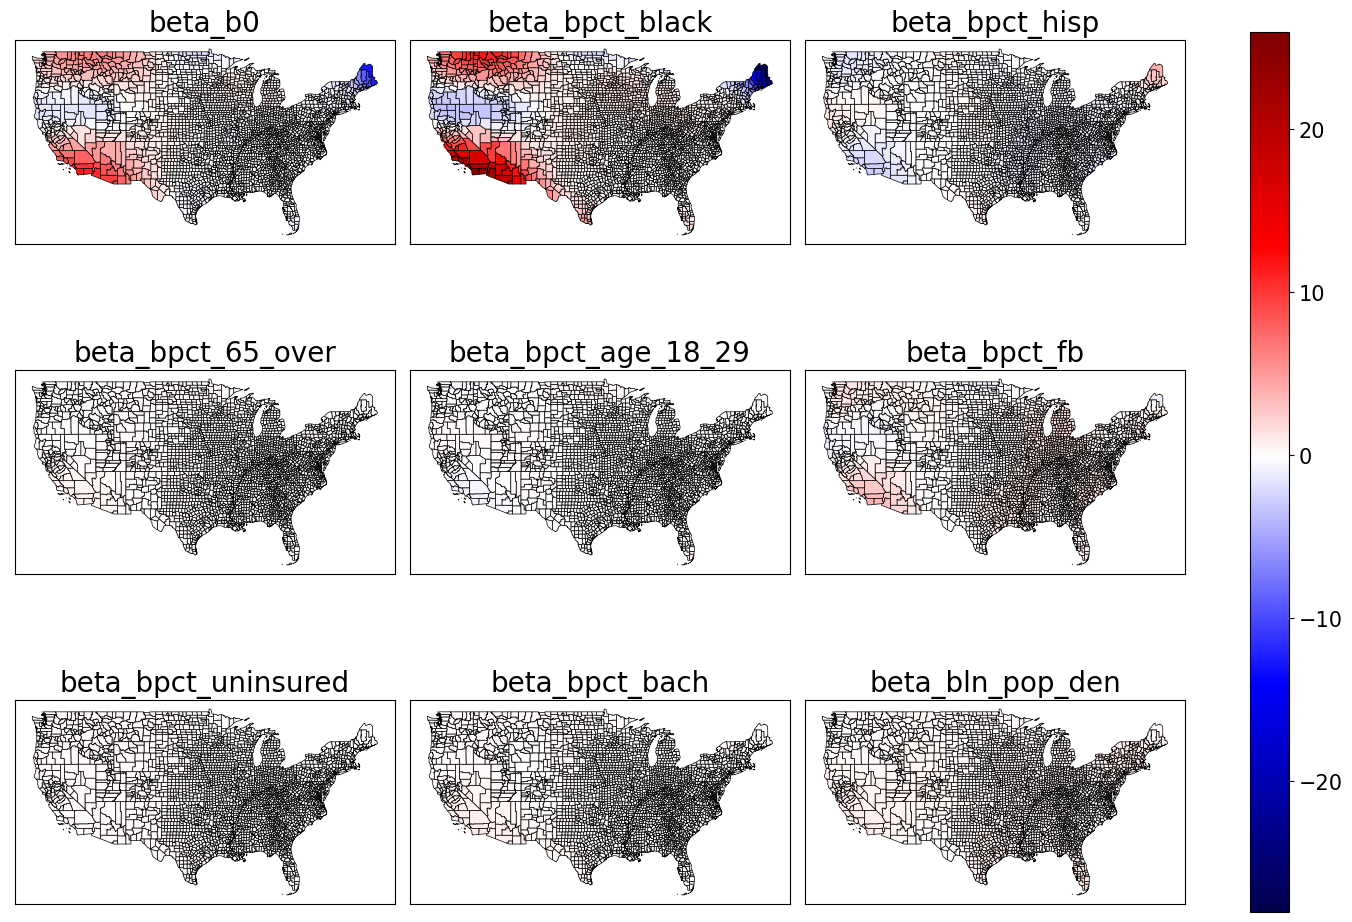

In [23]:
betas = [col for col in df3.columns if col.startswith('b')]
std_e = [col for col in df3.columns if col.startswith('se')]

viz_gw(
        data['geometry'], 
        df3[betas], 
        df3[std_e], 
        alpha=0.05,
        use_tvalues=False,
#         coef_surfaces=['beta_bpct_hisp']
)

#### Similar to utility 1,  the user specifies what surfaces they want to visualize, following best practices we recommend in the paper

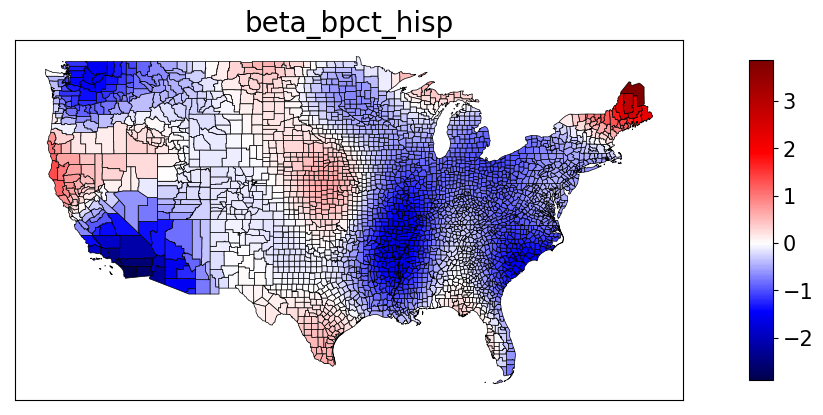

In [24]:
viz_gw(
        data['geometry'], 
        df3[betas], 
        df3[std_e], 
        alpha=0.05,
        use_tvalues=False,
        coef_surfaces=['beta_bpct_hisp']
)

<!-- The dependent variable here is the number of democratic votes and all these others 
are the independent variable. Thanks for watching! -->

<br />

--

## Utility 3

- The svc-viz tool can also be used to visualize the coefficients of two different SVC models to understand the underlying processes and relationships that exist within that geographical contexts and more importantly assess the similarities or differences between one model's specification over the other.

- This method takes as input: the original dataframe, the dataframe of the model estimates and their standard errors, the name of the coefficient that the user wishes to visualize, and the level of statistical significance for the tvalues of both SVC models. By default, it is set to 0.05

- below is an example using a GWR model and a GAM with Gaussian process splines calibrated on the same dataset. 

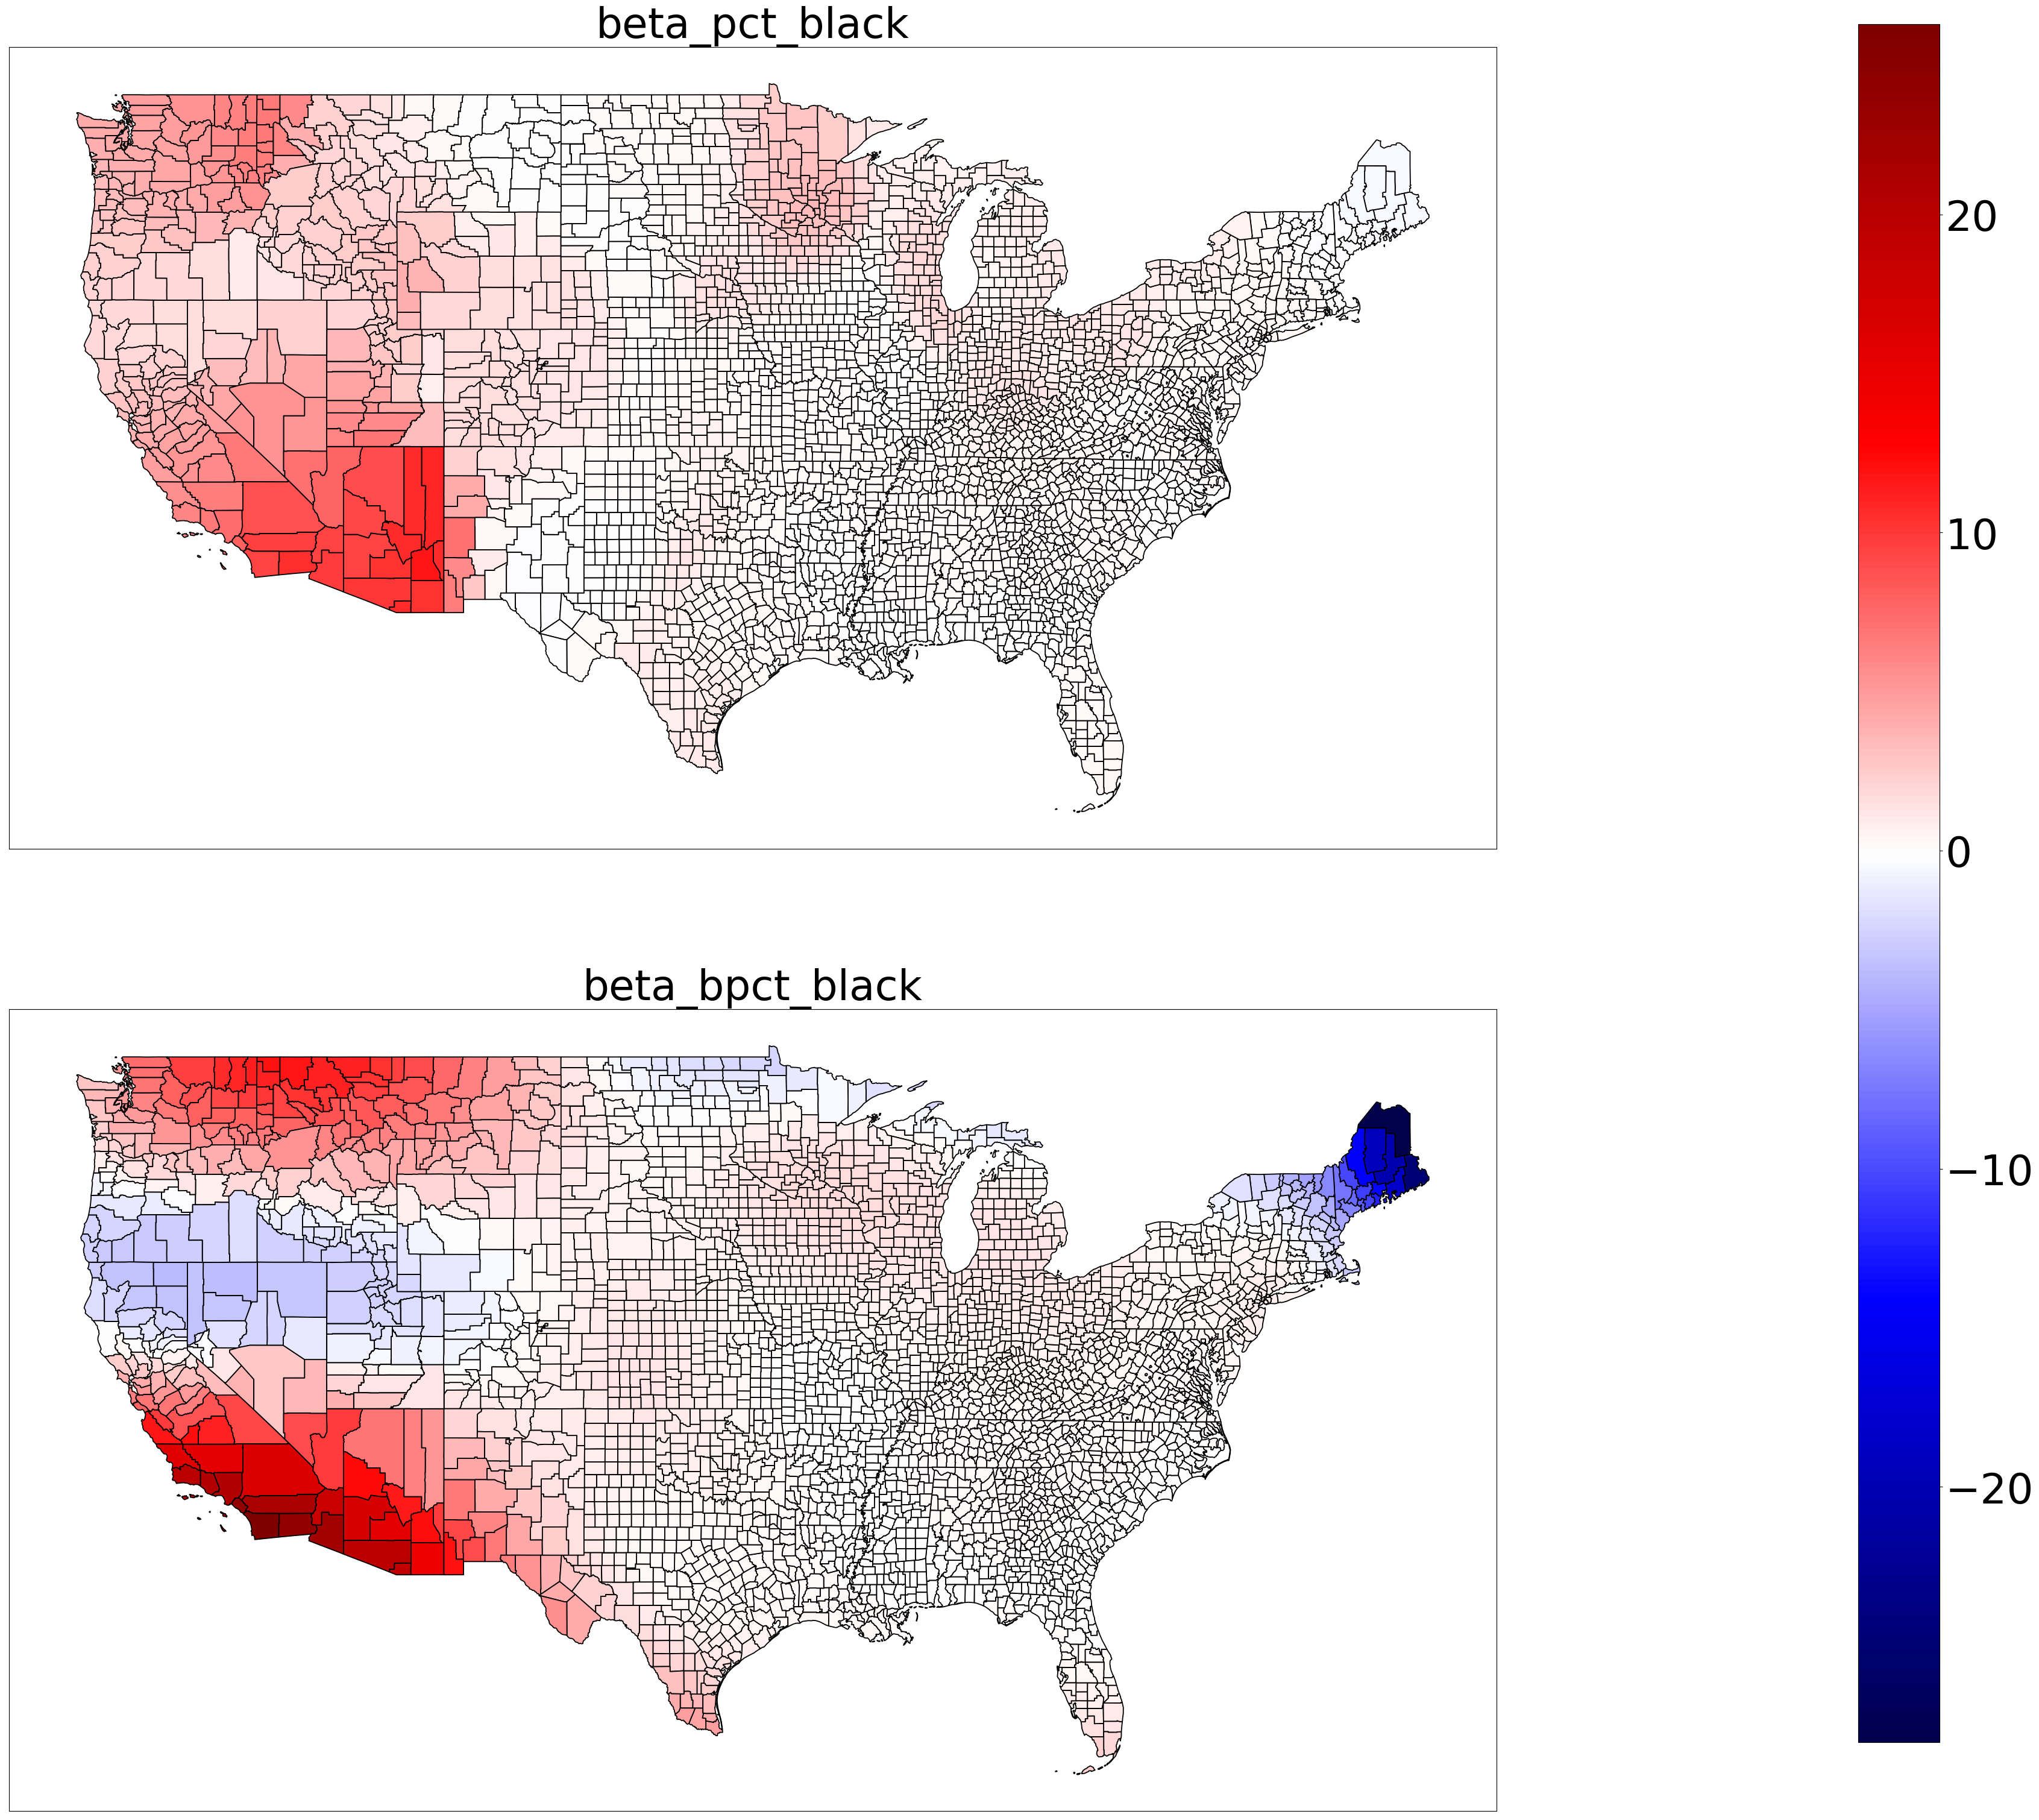

In [25]:
col_names = ['intercept']+col_names

gwr_est = pd.DataFrame(gwr_results.params, columns=col_names)
gwr_std = pd.DataFrame(gwr_results.bse, columns=col_names)

betas = [col for col in df3.columns if col.startswith('b')]
std_e = [col for col in df3.columns if col.startswith('se')]

compare_two_surf(data['geometry'], 
                 gwr_est, 
                 gwr_std, 
                 df3[betas],
                 df3[std_e], 
                 'beta_pct_black', 
                 'beta_bpct_black',
                  use_tvalues=False
)

<br />

## Utility 4

- The svc-viz tool can generate  a simple plot of confidence intervals to see locations where two different models overlap - as a measure of replication. The user specifies the level of significance, but by default we set it to 95%. However, as per schenker et al. 2001, overlapping confidence intervals alone are not enough to assess that they are same. More testing is required, e.g hypothesis testing with t-tests, which is part of the best practices we recommend and is incorporated in this tool.

- This method takes as input: the original dataframe, the dataframe of the model estimates and their standard errors, the name of the coefficient that the user wishes to visualize, and the level of statistical significance for the tvalues of both SVC models. By default, it is set to 0.05

- Below is an example code that plots a map showing locations where the confidence intervals of two svc models overlap and where they do not. Here we use the GWR model and the GAM calibrated with Gaussian process splines on the same datasets

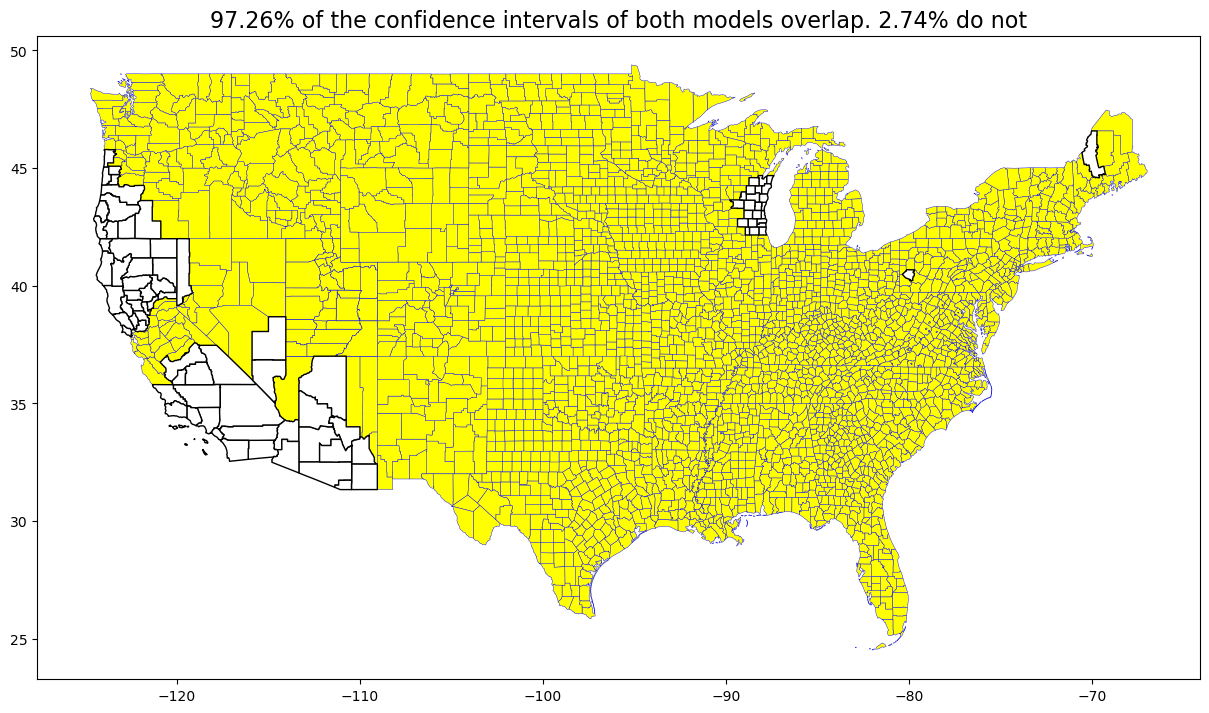

In [57]:
compare_conf(
    data['geometry'],
    gwr_est, 
    gwr_std, 
    df3[betas],
    df3[std_e],
    'pct_hisp',
    'bpct_hisp',
)

<br/>

### 3-panel Visualization

viz_gwr(
        col_names, 
        data['geometry'], 
        gwr_results, 
        use_tvalues=False, 
        alpha=0.5, 
        coef_surfaces=['pct_black']
)

In [80]:
fits = []
# The tqdm function is called with the iterable that we are looping over, in this case, range(25, len(data))
for i in tqdm(range(100, len(data), 100), desc='Fitting models', unit='model'):
    fits.append(GWR(g_coords, g_y, g_X, i).fit().aicc)

    col_names = ['pct_black', 'pct_hisp', 'pct_65_over', 'pct_age_18_29', 'pct_fb', 
    'pct_uninsured', 'pct_bach', 'ln_pop_den']

# str(gwr_selector.__class__)#.split('.')#[0]==("<class 'mgwr")

Fitting models: 100%|████████████████████████| 31/31 [01:58<00:00,  3.84s/model]


In [83]:
# viz_gwr(data, col_names, gwr_results, 
#          coef_surfaces=['intercept'], gwr_selector=gwr_selector,
#             aicc=fits)

TypeError: viz_gwr() got an unexpected keyword argument 'gwr_selector'

In [194]:
def viz_gwr(df, col_names, gwr_object, coef_surfaces=None, gwr_selector=None, aicc=None):
    
    # if 3-panel is true and coef_surf is not None or has 
    # more than one values throw error saying you must have only one surface 
    # for the 3 panel viz. 
    
    if coef_surfaces is None or len(coef_surfaces) != 1:
        raise ValueError("You must have only one surface for the 3 panel visualization.")
    
    params = gpd.GeoDataFrame(gwr_object.params, columns=['intercept'] + 
                              col_names, geometry=df['geometry'])     
   
    df['intercept'] = params['intercept']
    
    
    tvl = pd.DataFrame(gwr_object.filter_tvals(), 
                           columns=['t_intercept'] + ['t_'+col for col in col_names])
        
    bse = gpd.GeoDataFrame(gwr_object.bse, columns=['se_intercept'] + # is geometry !
                               ['se_'+col for col in col_names], geometry=df['geometry'])

    t_coefname = 't_' +coef_surfaces[0]
    se_coefname = 'se_' +coef_surfaces[0]
    threePanel(tvl[t_coefname], bse[se_coefname], params, 
               coef_surfaces, gwr_object, df, fits=aicc ) # maybe pass in gwr_selector



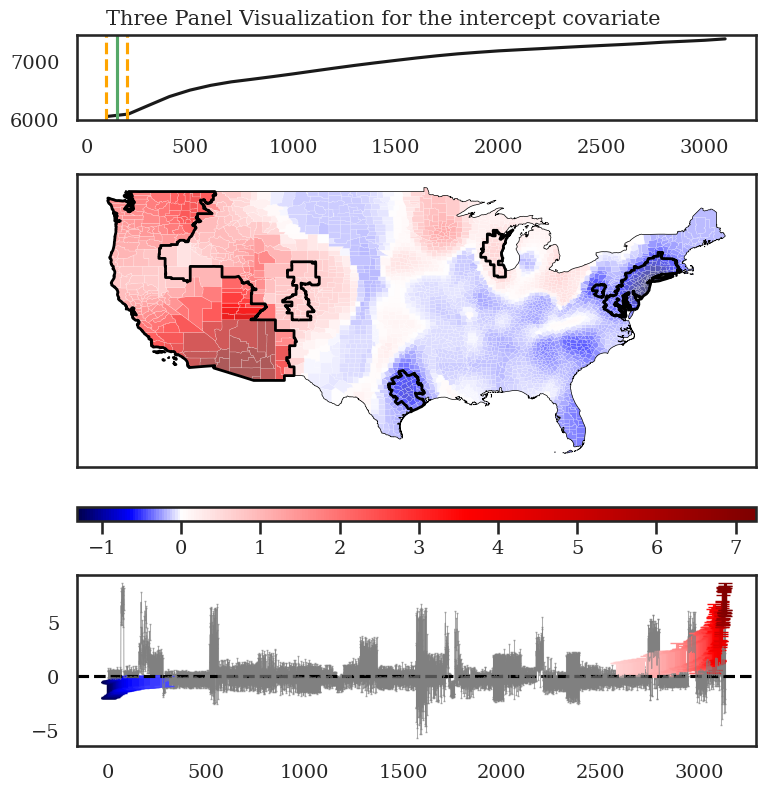

In [214]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def threePanel(var_t, var_se, params, coef_surfaces, gwr_object, df, fits ):
    fig, ax = plt.subplots(
            3, 1,
            figsize=(8,8), 
            gridspec_kw={'height_ratios':[1, 8, 2]})
    
    bw = gwr_selector.search()
    
    fig.subplots_adjust(hspace=-0.5)
    

    if isinstance(bw, list):#__class__).split('.')[0]==("<class 'mgwr"):
        mgwr_bw = gwr_selector.search() # check if colnames == bandwidths number
        print(mgwr_bw)
        names_bw = dict(zip(col_names, mgwr_bw))
        mgwr_coef_bw = names_bw[coef_surf]

        ax[0].plot(range(24, len(var_t)), fits, c='k')
        
        ax[0].axvline(mgwr_coef_bw, c='g')
        ax[0].axvline(mgwr_coef_bw-100, c='orange', linestyle='--')
        ax[0].axvline(mgwr_coef_bw+100, c='orange', linestyle='--')
        

    else:
        gwr_bw = gwr_selector.search()

        ax[0].plot(range(100, len(var_t), 100), fits, c='k')
        ax[0].axvline(gwr_bw, c='g')
        ax[0].axvline(gwr_bw-50, c='orange', linestyle='--')
        ax[0].axvline(gwr_bw+50, c='orange', linestyle='--')
        ax[0].tick_params(axis='both', labelsize=14)

    #Set color map
    cmap = plt.cm.seismic
    #Find min and max values of the two combined datasets
    gwr_min = params[coef_surfaces].min()
    gwr_max = params[coef_surfaces].max()
    vmin = np.min([gwr_min])
    vmax = np.max([gwr_max])

    #If all values are negative use the negative half of the colormap
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)

    #If all values are positive use the positive half of the colormap
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
    else:
        cmap = shift_colormap(cmap, 
                              start=0.0,
                              midpoint=1 - vmax / (vmax + abs(vmin)), 
                              stop=1.)

    #Create scalar mappable for colorbar and stretch colormap across range of data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
        vmin=vmin, vmax=vmax))

    # Middle Map
    # kwargs1 = {'edgecolor': 'white', 'alpha': .65}
    kwargs1 = {'edgecolor': 'white', 'alpha': .65, 'linewidth':0.2}
    

    params['geometry'] = params.buffer(0)
    gpd.GeoSeries(params.unary_union.boundary).plot(
                                                ax=ax[1], 
                                                color='black', 
                                                linewidth=0.5
                                             )
    params.plot(coef_surfaces[0], cmap=sm.cmap, ax=ax[1], vmin=vmin, vmax=vmax, **kwargs1)
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("bottom", size="5%", pad=0.4)
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=14)

    ax[1].tick_params(
        axis='both',         
        which='both', 
        bottom=False,      
        top=False, 
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False
    ) 

    if isinstance(bw, list):   
        mgwr_crit = gwr_object.critical_tval()
        names_crit = dict(zip(col_names, mgwr_crit))
        mgwr_names_crit = names_crit[coef_surf]  
        df = df.sort_values(coef_surf).reset_index().drop('index', axis=1)
        clust1 = df[df[var_t] > mgwr_names_crit]
        gpd.GeoSeries(clust1.unary_union.boundary).plot(ax=ax[1], color='black', linewidth=0.5)
        clust2 = df[df[var_t] < -1.*mgwr_names_crit]
        gp.GeoSeries(clust2.unary_union.boundary).plot(ax=ax[1], color='black', linewidth=0.5)

    else:
        crit = gwr_object.critical_tval()
        df['var_t'] = var_t
        df['var_se'] = var_se
        df = df.sort_values(coef_surfaces).reset_index().drop('index', axis=1)
        clust1 = df[df['var_t'] > crit]
        if not clust1.empty:
            gpd.GeoSeries(clust1.unary_union.boundary).plot(ax=ax[1], color='black', linewidth=2)
        else:
            print('clust1 is empty')
        clust2 = df[df['var_t'] < -1.*crit]
        if not clust2.empty:  # Check if clust2 is not empty
            gpd.GeoSeries(clust2.unary_union.boundary).plot(ax=ax[1], color='black', linewidth=2)
        else:
            print("clust2 is empty.")
#         gpd.GeoSeries(clust2.unary_union.boundary).plot(ax=ax[1], color='black', linewidth=2)

#     print(params[coef_surfaces].values.flatten())
    
    ax[2].errorbar(range(len(df)), 
               params[coef_surfaces].values.flatten(), 
               yerr = crit * var_se.values,
               ecolor='grey', 
               capsize=1, 
               c='grey', 
               alpha=.65, 
               lw=.75
            )

    color1 = np.array([(sm.to_rgba(v)) for v in clust1[coef_surfaces[0]].values.flatten()])
    
    #loop over each data point to plot
    for x, y, e, c in zip(clust1.index, 
                      clust1[coef_surfaces[0]].values.flatten(), 
                      crit*clust1['var_se'], 
                      color1):
        ax[2].errorbar(x, y, e, lw=2.25, capsize=5, c=c)

    color2 = np.array([(sm.to_rgba(v)) for v in clust2[coef_surfaces[0]].values.flatten()])
    #loop over each data point to plot
    for x, y, e, c in zip(clust2.index, 
                        clust2[coef_surfaces[0]].values.flatten(), 
                        crit*clust2['var_se'], 
                        color2):
        ax[2].errorbar(x, y, e, lw=2.25, capsize=5, color=c)

    ax[2].axhline(0, c='black', linestyle='--')
    ax[2].tick_params(axis='both', labelsize=14)
    
    fig.tight_layout()
    fig.suptitle(f'Three Panel Visualization for the {coef_surfaces[0]} covariate', fontsize=15, va='baseline')  # Add this line for the title
    plt.savefig('3panel2.png')
    plt.show()
    
viz_gwr(data, col_names, gwr_results, 
         coef_surfaces=['intercept'], gwr_selector=gwr_selector,
            aicc=fits)

In [81]:
str(gwr_selector.__class__)#.split('.')#[0]==("<class 'mgwr")

"<class 'mgwr.sel_bw.Sel_BW'>"

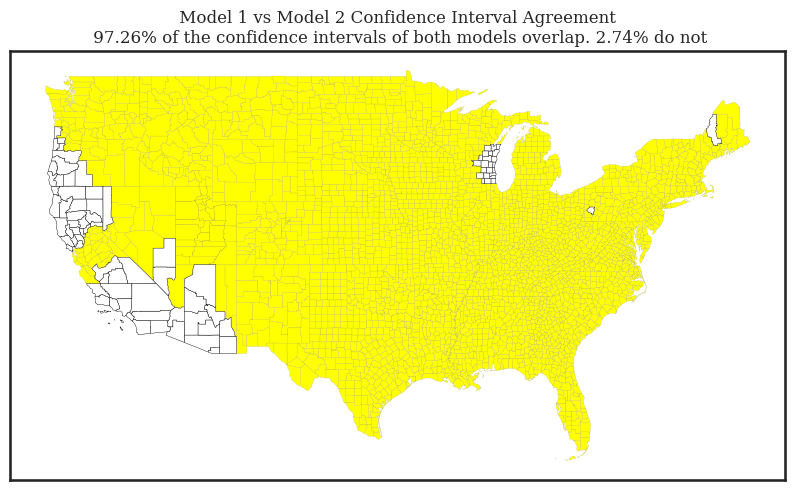

In [115]:
compare_conf(
    data['geometry'],
    gwr_est, 
    gwr_std, 
    df3[betas],
    df3[std_e],
    'pct_hisp',
    'bpct_hisp',
)

length is: 2735


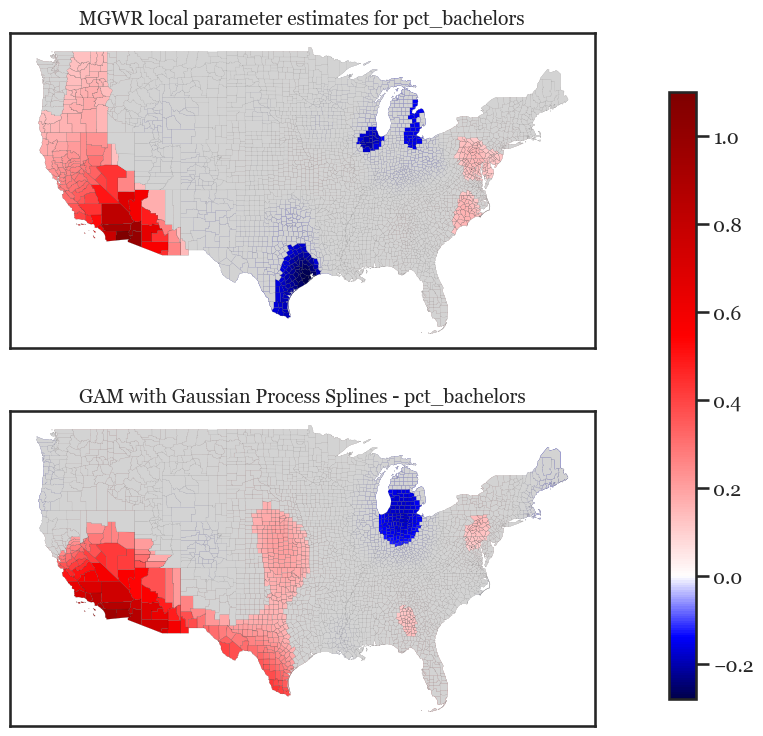

In [85]:
col_names = ['pct_black', 'pct_hisp', 'pct_65_over', 'pct_age_18_29', 'pct_fb', 
    'pct_uninsured', 'pct_bach', 'ln_pop_den']

col_names = ['intercept']+col_names

gwr_est = pd.DataFrame(mgwr_results.params, columns=col_names)
gwr_std = pd.DataFrame(mgwr_results.bse, columns=col_names)


betas = [col for col in df3.columns if col.startswith('b')]
std_e = [col for col in df3.columns if col.startswith('se')]


compare_two_surf(data['geometry'], 
                 gwr_est, 
                 gwr_std, 
                 df3[betas],
                 df3[std_e], 
                 'beta_pct_bach', 
                 'beta_bpct_bach',
                  use_tvalues=True
)

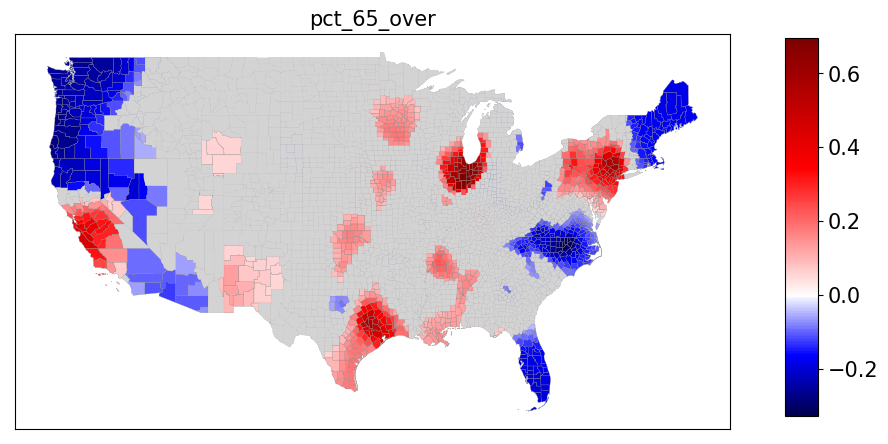

In [40]:
col_names = ['pct_black', 'pct_hisp', 'pct_65_over', 'pct_age_18_29', 'pct_fb', 
                                                     'pct_uninsured', 'pct_bach', 'ln_pop_den']

viz_gwr( 
        col_names, 
        data['geometry'], 
        gwr_results, 
        use_tvalues=True, 
        alpha=0.5,   
        coef_surfaces=['pct_65_over']
)

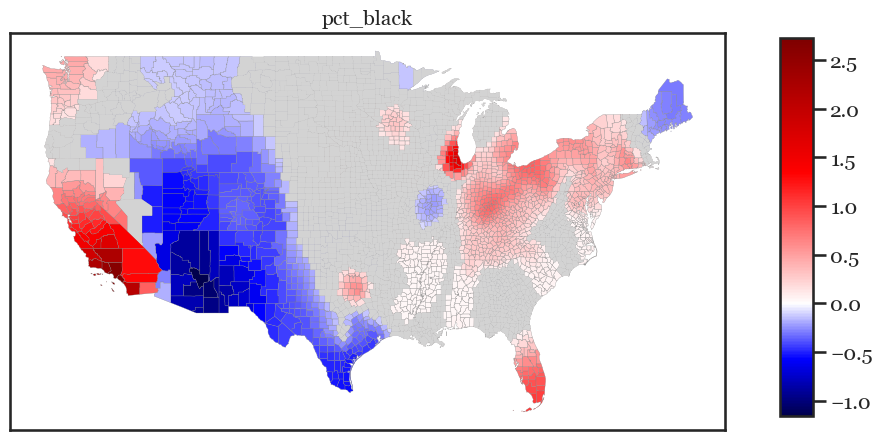

In [48]:
viz_gwr( 
        col_names, 
        data['geometry'], 
        mgwr_results, 
        use_tvalues=True, 
        alpha=0.5,   
        coef_surfaces=['pct_black']
)

In [71]:
# mgwr_results.summary()

In [72]:
# dir(mgwr_results)

In [76]:
import matplotlib.pyplot as plt
import geopandas as gp

def _compare_surfaces(data, var1, var2, var1_t, var2_t, use_tvalues=False, savefig=None):
    '''
    Function that creates comparative visualization of GWR and MGWR surfaces.
    Parameters
    ----------
    data   : pandas or geopandas Dataframe
             gwr/mgwr results
    var1   : string
             name of gwr parameter estimate column in frame
    var2   : string
             name of mgwr parameter estimate column in frame
    gwr_t  : string
             name of gwr t-values column in frame associated with var1
    gwr_bw : float
             bandwidth for gwr model for var1
    mgwr_t : string
             name of mgwr t-values column in frame associated with var2
    mgwr_bw: float
             bandwidth for mgwr model for var2
    name   : string
             common variable name to use for title
    kwargs1:
             additional plotting arguments for gwr surface
    kwargs2:
             additional plotting arguments for mgwr surface
    savefig: string, optional
             path to save the figure. Default is None. Not to save figure.
    '''

    

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 9))
    ax0 = axes[0]
#     ax0.set_title('Scenario '+ name + ' ' + data[var1].name.upper(), fontsize=40)
    # ax0.set_title(var1, fontsize=14)
    ax0.set_title('MGWR local parameter estimates for pct_bachelors', fontsize=14)
    
    ax1 = axes[1]
#     ax1.set_title('Scenario '+ name + ' ' + data[var2].name.split('_')[0].upper(), fontsize=40)
    # ax1.set_title(var2, fontsize=14)
    ax1.set_title('GAM with Gaussian Process Splines - pct_bachelors', fontsize=14)
    

    #Set color map
    cmap = plt.cm.seismic

    #Find min and max values of the two combined datasets
    improved_min = data[var1].min()
    improved_max = data[var1].max()
    classic_min = data[var2].min()
    classic_max = data[var2].max()
    vmin = np.min([improved_min, classic_min])
    vmax = np.max([improved_max, classic_max])
    #If all values are negative use the negative half of the colormap
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    #If all values are positive use the positive half of the colormap
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
    else:
        cmap = shift_colormap(cmap, start=0.0,
                              midpoint=1 - vmax / (vmax + abs(vmin)), stop=1.)

    #Create scalar mappable for colorbar and stretch colormap across range of data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
        vmin=vmin, vmax=vmax))

    #Plot GWR parameters
    data.plot(var1, cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, edgecolor='k', linewidth=.1)
    if (data[var1_t]==0).any() and use_tvalues==True:
        print('length is:', len(data[data[var1_t]==0]))
        data[data[var1_t]==0].plot(color='lightgrey', edgecolor='grey', ax=ax0, linewidth=.05)

    #Plot MGWR parameters
    data.plot(var2, cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, edgecolor='k', linewidth=.1)
    if (data[var2_t]==0).any() and use_tvalues==True:
        data[data[var2_t]==0].plot(color='lightgrey', edgecolor='grey', ax=ax1, linewidth=.05)

    #Set figure options and plot
#     fig.tight_layout()
    fig.subplots_adjust(right=0.9)
    cax = fig.add_axes([0.92, 0.14, 0.03, 0.675])
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=14)
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    
    
    
def compare_two_surf(df_geo, est1, stderr1, est2, stderr2, var1,
                     var2, use_tvalues=False, alpha=0.05):
    """
        Compare the surfaces of two estimated models for specific variables,
        with an option to overlay t-values to highlight significant regions.
        ===========================
        Parameters:
            - df_geo (Geometry): The geometry column of the main dataframe.
            - est1 (DataFrame): The DataFrame containing beta coefficients of the first model.
            - stderr1 (DataFrame): The DataFrame containing standard errors corresponding to beta coefficients of the first model.
            - est2 (DataFrame): The DataFrame containing beta coefficients of the second model.
            - stderr2 (DataFrame): The DataFrame containing standard errors corresponding to beta coefficients of the second model.
            - var1 (str): The specific variable of interest from the first model to be compared.
            - var2 (str): The specific variable of interest from the second model to be compared.
            - use_tvalues (bool): Whether to overlay t-values on the surfaces to highlight significant regions. Defaults to False.
            - alpha (float): The significance level for filtering t-values. Defaults to 0.05.

        Returns:
            - None: Displays the comparative surfaces plots with optional t-values overlaid.
    """

    est1.columns = ['beta_'+col if not col.startswith('beta_') else col for col in est1.columns]
    stderr1.columns = ['std_'+col if not col.startswith('std') else col for col in stderr1.columns]
    model_1 = merge_index(est1, stderr1)
    model_1mask = mask_insignificant_t_values(model_1.copy(), alpha=alpha)
    tvals = model_1mask[[col for col in model_1mask.columns if col.startswith('t')]]
    model_1df = merge_index(model_1, tvals)
    
    
    est2.columns = ['beta_'+col for col in est2.columns]
    stderr2.columns = ['std_'+col for col in stderr2.columns]
    data = merge_index(est2, stderr2)  
    model2_mask = mask_insignificant_t_values(data.copy(), alpha=alpha)
    model2_tvals = model2_mask[[col for col in model2_mask.columns if col.startswith('t')]]
    
    model_2 = merge_index(data, model2_tvals)
    data_df = gpd.GeoDataFrame(merge_index(model_1df, model_2), geometry=df_geo)

    t_var1 = 't_'+var1
    t_var2 = 't_'+var2

    _compare_surfaces(data_df, var1, var2, t_var1, 
                     t_var2, use_tvalues=use_tvalues)


In [1]:
print('hello')

hello


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
from shapely import wkt
import scipy.stats as stats

# Set the Seaborn theme, context, and palette
# sns.set_theme(style='white', context='talk')
sns.set_theme(style='white', context='talk', rc={'font.family':'serif', 'font.serif':['Georgia'], 'font.size':13})


sns.set_palette('bright')

# Serif: 'serif', 'Times New Roman', 'Palatino', 'New Century Schoolbook', 'Bookman', 'Georgia', etc.
# Sans-serif: 'sans-serif', 'Arial', 'Helvetica', 'Lucida Grande', 'Verdana', 'Geneva', etc.
# Monospace: 'monospace', 'Courier New', 'DejaVu Sans Mono', 'Lucida Console', etc.
# Cursive: 'cursive', 'Zapf Chancery', 'Comic Sans MS', etc.
# Fantasy: 'fantasy', 'Comic Sans MS', 'Chicago', etc.

# Shift Colormap Function
def shift_colormap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    import matplotlib as mpl
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    reg_index = np.linspace(start, stop, 257)
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    new_cmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    return new_cmap

# Truncate Colormap Function
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    import matplotlib as mpl
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap



def compare_surfaces_grid(data, vars, use_tvalues=True, savefig=None):
    n_vars = len(vars)
    tvalues = ['t_' + var for var in vars]  # Automatically generate tvalue column names

    grid_dim = int(np.ceil(np.sqrt(n_vars)))
    
    # Adjusting the figsize based on number of variables
    if n_vars in [1, 2]:
        figsize = (11, 9 * n_vars)  # Adjusting the height for 1 variable
        fig, axes = plt.subplots(nrows=n_vars, ncols=1, figsize=figsize)
    else:
        figsize = (13, 11)
        fig, axes = plt.subplots(nrows=grid_dim, ncols=grid_dim, figsize=figsize)
        
    
    if n_vars == 1 :
        axes = [axes]
    else:
        axes = axes.ravel()

    cmap = plt.cm.seismic
    vmin = min(data[var].min() for var in vars)
    vmax = max(data[var].max() for var in vars)
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    else:
        cmap = shift_colormap(cmap, start=0.0,
                              midpoint=1 - vmax / (vmax + abs(vmin)), stop=1.)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    for i, var in enumerate(vars):
        ax = axes[i]
        ax.set_title(var, fontsize=15)
        data.plot(var, cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, edgecolor='grey', linewidth=0.2)
        if use_tvalues:
            tvalue_col = tvalues[i]
            data[data[tvalue_col] == 0].plot(color='lightgrey', edgecolor='black', ax=ax, linewidth=0.005)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if n_vars > 2:
        for j in range(i+1, grid_dim*grid_dim):
            axes[j].axis('off')
            
    fig.subplots_adjust(left=0.05, right=0.70, bottom=0.05, top=0.70, wspace=0.04, hspace=-0.35)
    
    cax = fig.add_axes([0.75, 0.17, 0.03, 0.42])
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=15)
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

        

def viz_gwr(col_names, df_geo, gwr_object, use_tvalues=True,  alpha=0.05, coef_surfaces=None):
    data = gpd.GeoDataFrame(gwr_object.params, geometry=df_geo)
    col_names = ['intercept'] + col_names + ['geometry']
    data.columns = col_names

    tvl = pd.DataFrame(gwr_object.filter_tvals(alpha=alpha))
    tvl.columns = ['t_'+col for col in col_names if col !='geometry']
    merged = data.merge(tvl, left_index=True, right_index=True)

    col_names.pop()
    
    tval_names = [col for col in merged.columns if col.startswith('t')]
    if coef_surfaces is not None:
        compare_surfaces_grid(merged, coef_surfaces, use_tvalues=use_tvalues)
    else:
        compare_surfaces_grid(merged, col_names, use_tvalues=use_tvalues)
        


def mask_insignificant_t_values(df, alpha=0.05):
    """
        Calculate t-values from a dataframe containing coefficients and their standard errors.
        Mask insignificant t-values with zero.

        Args:
            - df (pd.DataFrame): Dataframe containing columns with coefficients (prefixed with "b") and standard errors (prefixed with "se").
            - alpha (float): Significance level. Default is 0.05 (95% confidence).

        Returns:
            - pd.DataFrame: A new dataframe with coefficients and t-values, where insignificant t-values are set to zero.
    """
    
    coefficient_cols = [col for col in df.columns if col.startswith("beta")]
    se_cols = [col for col in df.columns if col.startswith("std")]
    
    # Check if the number of coefficient columns matches the number of standard error columns
    if len(coefficient_cols) != len(se_cols):
        raise ValueError("Mismatch in number of coefficient and standard error columns.")
    
    # Calculate t-values
    for coeff_col, se_col in zip(coefficient_cols, se_cols):
        t_value_col = f"t_{coeff_col}"
        df[t_value_col] = df[coeff_col] / df[se_col]
    
    # Calculate degrees of freedom (assuming we're in the context of linear regression)
    # df - number of predictors - 1
    degrees_of_freedom = len(df) - len(coefficient_cols) - 1
    
    # Calculate critical t-value from the t-distribution
    critical_t_value = stats.t.ppf(1 - alpha/2, degrees_of_freedom)
    
    # Mask where t-values are insignificant
    insignificant_mask = df.filter(like="t_").abs().le(critical_t_value)
    # Set t-values to zero where they are insignificant
    for t_value_col in df.filter(like="t_").columns:
        df.loc[insignificant_mask[t_value_col], t_value_col] = 0
    
    return df


def merge_index(left, right):
    return left.merge(right, left_index=True, right_index=True)


def viz_gwstat(df_geo, betas, std_errs, use_tvalues=True, coef_surfaces=None, alpha=0.05):
    # data = gpd.GeoDataFrame(betas, geometry=df_geo) # throw exception if columns are not named
    betas.columns = ['beta_'+col for col in betas.columns]
    
    std_errs.columns = ['std_'+std for std in std_errs.columns]
    # col_names = col_names + ['geometry']
    
    data = merge_index(betas, std_errs)  # merge beta+std_errors
    mask = mask_insignificant_t_values(data.copy(), alpha=alpha)
    tvals = mask[[col for col in mask.columns if col.startswith('t')]]

    # datamerged_tvls = merge_index(data, tvals)
    data_df = gpd.GeoDataFrame(merge_index(data, tvals), geometry=df_geo)
#     print(data_df)
    betas = betas.columns 
    col_tvals = [col for col in tvals]
    if coef_surfaces is not None:
        compare_surfaces_grid(data_df, coef_surfaces, use_tvalues=use_tvalues)
    else:
        compare_surfaces_grid(data_df, betas, use_tvalues=use_tvalues)
    
def compare_conf(df_geo, est1, stderr1, est2, stderr2, var1,
                     var2, z_value=1.96):
    from viz_gwr import merge_index
    
    est1.columns = ['beta_'+col if not col.startswith('beta_') else col for col in est1.columns]
    stderr1.columns = ['std_'+col if not col.startswith('std') else col for col in stderr1.columns]
    model_1 = merge_index(est1, stderr1)
    
    est2.columns = ['beta_'+col for col in est2.columns]
    stderr2.columns = ['std_'+col for col in est2.columns]
    data = merge_index(est2, stderr2)  
    
    data_df = gpd.GeoDataFrame(merge_index(model_1, data), geometry=df_geo)
        
    model_1['lower_'+var1] = model_1['beta_'+var1] - z_value * model_1['std_'+var1]
    model_1['upper_'+var1]  = model_1['beta_'+var1] + z_value * model_1['std_'+var1]
    
    data['lower_'+var2] = data['beta_'+var2] - z_value * data['std_beta_'+var2]
    data['upper_'+var2] = data['beta_'+var2] + z_value * data['std_beta_'+var2]

    data_df[var1] = ((model_1['lower_'+var1] <= data['upper_'+var2]) &
                     (model_1['upper_'+var1] >= data['lower_'+var2]))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    data_df[data_df[var1]].plot(ax=ax, color='yellow', edgecolor='grey', linewidth=.1, label='Overlap')
    data_df[~data_df[var1]].plot(ax=ax, color='white', edgecolor='black', linewidth=0.3, label='Overlap')
    plt.xticks([])
    plt.yticks([])
    
    ax.set_title(f' Model 1 vs Model 2 Confidence Interval Agreement \n {round(data_df[var1].sum()/len(data_df)*100, 2)}% of the confidence intervals of both models overlap. {round(100-(data_df[var1].sum()/len(data_df)*100), 2)}% do not', fontsize=12);

<br />

<br />